## Supervised Learning
## Project: Finding Donors for *CharityML*

#### Note: Udacity can be credited for some of the Markdown text in this notebook. I have removed some of Udacity's guidance text to make the notebook easier to read.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py (provided by Udacity)
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration

In [2]:
# Review feature data types
display(data.head(n=5))
data.dtypes

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


age                  int64
workclass           object
education_level     object
education-num      float64
marital-status      object
occupation          object
relationship        object
race                object
sex                 object
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country      object
income              object
dtype: object

In [3]:
# Get quick view of response variable distribution
n_records = len(data.index)
n_greater_50k = (data['income']==">50K").sum()
n_at_most_50k = (data['income']=="<=50K").sum()
greater_percent = 100 * n_greater_50k / n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data

### Transforming Skewed Continuous Features

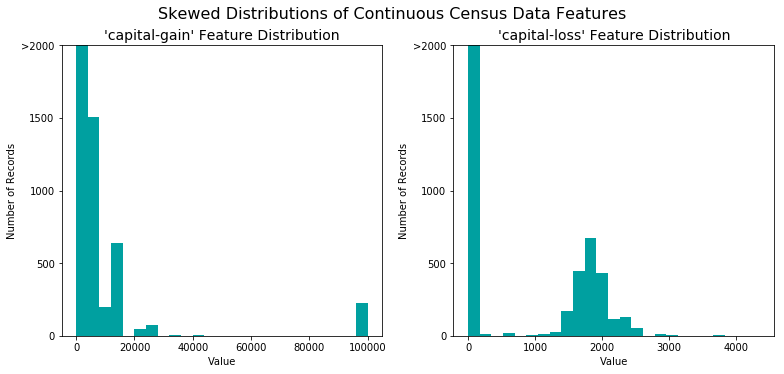

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

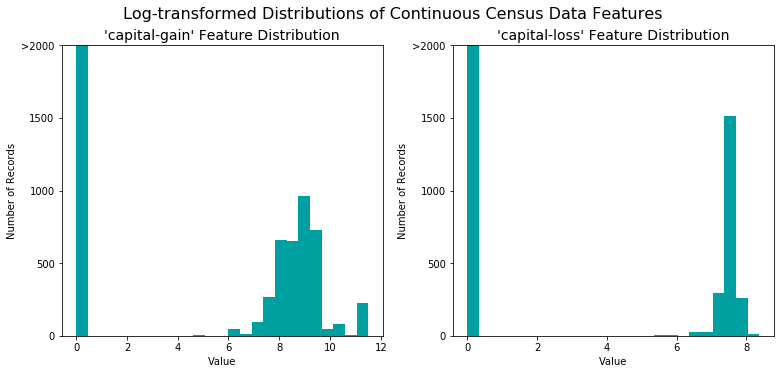

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features

In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

In [7]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = pd.Series(map(int, income_raw==">50K"))

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

103 total features after one-hot encoding.


### Shuffle and Split Data
80% of the data will be used for training and 20% for testing.

In [8]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall.

### Question 1 - Naive Predictor Performace

In [9]:
# Calculate accuracy, precision and recall
accuracy = np.sum(income) / income.count()
recall = np.sum(income) / (np.sum(income) + 0)
precision = np.sum(income) / income.count()

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1+0.5*0.5) * (precision*recall) / (0.5*0.5*precision+recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **

#### Gaussian Naive Bayes
    
Gaussian Naive Bayes (GNB) models can be used for many classification problems. They have been used to categorize text and to diagnose medical patients.
    
GNB is computationally efficient and easy to implement. It performs well when modeling the functional form of P(Y,X) is straightforward. While it imposes strong assumptions, it tends to be robust to violations of those assumptions.
    
GNB imposes two strong assumptions about the data. First, the model assumes features are independent from one another. This is almost never the case in real world settings. In our data, for example, we would be assuming that educational level is independent of occupation. But we know, for exmaple, that many professional occupations (e.g. school teacher, doctor, lawyer) are by law restricted to thsoe with particular degrees or certifications. The GNB model also assumes continuous features have Gaussian distributions. This will rarely be the case. While GNB is a generally robust model, its performance can suffer when either of these two assumptions fail.

GNB is a good candidate because of the simplicity of our problem. Mostly, I have chosen it because I want to see how it performs relative to more complex models. A similar practice is used in public policy research, wherein an economist might report results from an OLS model for contrast with their preferred model that attempts to approximate the results of a randomized trial.

As an alternative to the GNB model, we could use logistic regression. Logistic regression is closely related to GNB. While GNB models the joint probability distribution P(Y,X), logistic regression is a conditional maximum likelihood model of P(Y|X). Unlike GNB, logistic regression does not assume features are independent beyond a standard rank assumption (i.e. logistic regression assumes there is one parameter vector for which the model is identical to P(Y|X)). Logistic regression also does not require assumptions about the distributions of feature variables. To obtain consistent estimatators, logistic regression does require conditional homoskedasticity of the target variable.


#### Gradient Boosting
    
Gradient Boosting is a technique that can improve the performance of a wide variety of estimators by augmenting results with an error correction term. Gradient Boosting has been used to improve search engine algorithms (https://en.wikipedia.org/wiki/Gradient_boosting).

Gradient Boosting is commonly used with decision tree models to effectively increase the flexibility of their functional form. While typical decision trees minimize a loss function locally at each decision point, Gradient Boosting uses an iterative procedure similar to stochastic gradient descent to minimize a global loss function. Gradient Boosting does not usually overfit models, and regularization techniques can be used to prevent overfitting.

Gradient Boosting can only be used with loss functions that have continuous first order conditions. Gradient Boosting can be relatively computationally intensive while offering little improvement over well-fit simpler models.

The large number of categorical variables in our data suggests a large number of interaction terms may improve model fit. Gradient Boosting can produce a flexible model.


#### Support Vector Machines
    
Support Vector Machines can be used for complex classification problems with discontinuous functional forms. SVMs have been used for image and text classification, for example.
    
SVM's can be applied to discontinuous functions by adding a spatial dimension to the data, fitting a function, and then projecting that function onto the N-1 dimensional space. SVM's can fit data with arbitrarily high accuracy.

SVM's commonly use nonparametric algorithms, making them computationally intensive and easy to overfit. Nonlinear SVM's are "black-box" models, meaning we cannot compare feature importance or express the models with closed-form equations.

SVM's can fit data nonparametrically and with high accuracy.



### Implementation - Creating a Training and Predicting Pipeline

In [10]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[0:sample_size], y_train[0:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[0:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[0:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[0:300], predictions_train, 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.


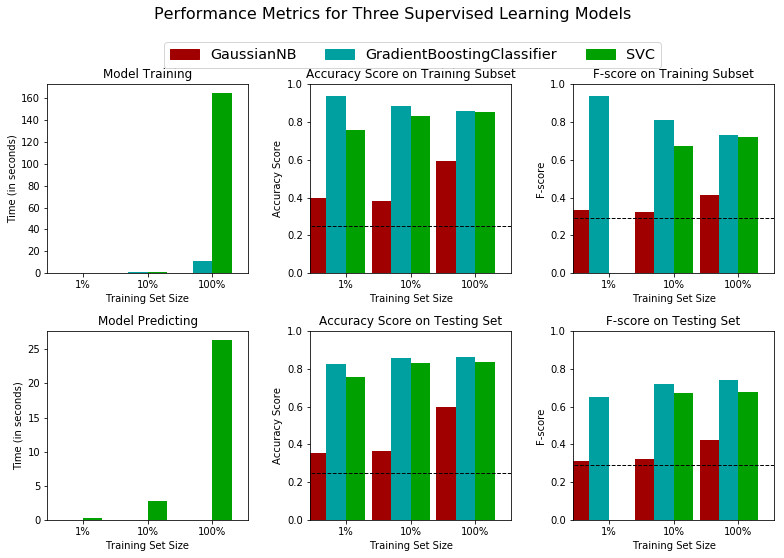

In [12]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# TODO: Initialize the three models
clf_A = GaussianNB()
clf_B = GradientBoostingClassifier(random_state=53)
clf_C = SVC(random_state=53)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# samples_100 is the entire training set i.e. len(y_train)
# samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(0.1*len(y_train))
samples_1 = int(0.01*len(y_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
# This visulation code was provided by Udacity
vs.evaluate(results, accuracy, fscore) 

----
## Improving Results

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

**Answer: **

The best performing model was the Gradient Boosting Classifier. The Gradient Boosting classifier also trained and predicted quickly--especially relative to the Support Vector Machine classifier. The algorithm has conceptual suitability to the data, in that it allows us to make dichotomous classifications conditional on features. It achieved the highest f-score and accuracy of the three models on both the testing and training data sets.

The Gaussian Naive Bayes algorithm performed poorly. This can be attributed to the known dependence between features and known non-Gaussian empirical distributions. For contrast, I also tested a logistic regression model. The logistic regression model performed nearly as well as the Gradient Boosting algorithm, and about as well as the Support Vector Machine. The logistic model can perform better than the Naive Bayes model in this context, despite their mathematical similarity, because logistic regression fully relaxes the most restrictive assumptions imposed by Naive Bayes. 

The logistic model's close performance to Gradient Boosting suggests it could potentially outperform Gradient Boosting were we to specify a correct functional form. This is not surprising given the simplicity of our prediction task, and that most of our features are categorical.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

**Answer: ** 
To predict whether a potential donor earns an income greater than $50k, we can use the information we have about each potential donor in a mathematical flow chart called a "decision tree". In this tree, we map a range of possible permutations of donor characteristics and use statistics to relate each permutation to an income category. For example, we might use our data to classify donors based on some combination of their gender and education level by splitting donors into groups of males and females and then splitting those gender-based groups further into groups of high school graduates and dropouts. We created this tree and used a technique called “gradient boosting” that iteratively adjusts it to correct for any initial mistakes.

We iteratively adjust for errors in the initial tree by adding in additional trees. While the first tree predicts income based on donor characteristics, the second tree predicts errors in the first tree based on donor characteristics. We use error estimates from the second tree to adjust the first tree. This creates a composite tree. Then we create a third tree to adjust for errors in the composite of the composite tree, creating a new tree that is the composite of three trees. We repeat the process a few hundred times, each time adjusting for errors in the composite of all previously adjusted trees. Each additional tree plays a lesser role than its predecessors because every tree we add gets us a little bit closer to the “optimal” tree.

All of the trees we combined into our optimal tree are called “weak learners”, while the optimal tree is called a “strong learner”. Weak learners can be very accurate or only slightly accurate, so long as they perform better than random chance. Some weak learners can be good at predicting small subsets of the data even if they perform poorly on other subsets. When we combine many weak learners into one strong learner, the resulting tree aggregates the strengths of the weak learners into a “strong” tree that is more effective than any of its “weak” components.

We developed our statistical model using data from a sample of potential donors, and then tested the model with a second sample of potential donors just to make sure the model we developed will work when it is deployed at your organization.

### Implementation: Model Tuning

In [13]:
# notable citation: https://machinelearningmastery.com/configure-gradient-boosting-algorithm/

# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = GradientBoostingClassifier(subsample=0.6, max_features=0.8, random_state=53)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'learning_rate': [0.08, 0.1],
              'n_estimators': [200, 300],
              'max_depth': [3, 4]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_
print(best_clf)

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print()
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.08, loss='deviance', max_depth=4,
              max_features=0.8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=53, subsample=0.6, verbose=0,
              warm_start=False)
Unoptimized model
------
Accuracy score on testing data: 0.8611
F-score on testing data: 0.7339

Optimized Model
------
Final accuracy score on the testing data: 0.8687
Final F-score on the testing data: 0.7458


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score | 86.11%            | 86.87%          |
| F-score        | 73.39%            | 74.58%          |


**Answer: **
The optimized model performed slightly better than sklearn's default model, and substantially better than the naive estimate of 24.78%. We could achieve better performance by increasing the range of parameters tested by the grid search algorithm, but computational limitations prevented me from doing so.

----
## Feature Importance

### Implementation - Extracting Feature Importance

In [2]:
# Extract the feature importances using .feature_importances_ 
importances = best_clf.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

NameError: name 'best_clf' is not defined

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**
I had not predicted that capital gain and capital loss would be among the most important predictors of income, but in hindsight it is obviously the case that those with capital assets are generally wealthy. Most Americans have no financial investments. I had correctly predicted that age, hours-per-week, and educational attainment were among the most important.

### Feature Selection

In [15]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8687
F-score on testing data: 0.7458

Final Model trained on reduced data
------
Accuracy on testing data: 0.8401
F-score on testing data: 0.6924


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**
The f-score drops about about five percentage points when we use only the five most important features. While in general it is sensible to use fewer features to reduce training time when doing so has little effect on results, we must consider the cumulative cost of marketing mistakes that could be prevented by paying for computation services. It is important that CharityML consider both the costs and benefits of such a decision.